### Init script to load contents if running on Google CoLab

In [1]:
# This code is for  Google CoLab

# mount google drive
from google.colab import drive
import sys

# copy data from google drive to local disk
drive.mount('/content/drive')
!cp -r drive/MyDrive/DeepLearning .

Mounted at /content/drive


# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [3]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

In [4]:
!nvidia-smi

Mon May  6 15:40:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Answer to Question 1:
The GPU used for training is Tesla T4 card on Google Colab. It supports up to 16GB of GPU memory and 2560 CUDA cores.

Nvidia RTX 3090 on the other hand, has 10,496 cuda core.

## Answer to Question 2:
According to the nvidia-smi info, the Tesla T4 card on Google Colab has 15360MiB GPU ram.

For Nvidia RTX 3090, it has 24 GB GDDR6X memory.

## Answer to Question 3:
The items stored in the GPU memory are:
1. Parameters of the model
2. Input data
3. Intermediate activation values during the forward process
4. Gradients values
5. Values of loss functions
6. Other variables may needed


# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [5]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('DeepLearning/Mirai_data.npy')
Y = np.load('DeepLearning/Mirai_labels.npy')

# Remove the first 24 covariates (columns)
print("columns before remove:",X.shape[1])
X = X[:,24:]
print("columns after remove:",X.shape[1])

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
values, counts = np.unique(Y, return_counts=True)
info = np.vstack([values,counts])
print(info)


columns before remove: 116
columns after remove: 92
The covariates have size (764137, 92).
The labels have size (764137,).
[[0.00000e+00 1.00000e+00]
 [1.21621e+05 6.42516e+05]]


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [6]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
# print out the sum of np.isnan(), if the output > 0 , it means nan values existed
# according to the output here. NO nan value in our dataset

# Print the number of NaNs (not a number) in the labels
print("The number of NaNs (not a number) in the labels:",np.sum(np.isnan(Y)))

# Print the number of NaNs in the covariates
print("The number of NaNs in the covariates:",np.sum(np.isnan(X)))



The number of NaNs (not a number) in the labels: 0
The number of NaNs in the covariates: 0


## Answer to question 4:

Accuracy formula is as follows

$$
Accuracy = \frac{\text{Num of correct predictions}}{\text{Total number of predictions}}
$$

The accuracy of it mainly depends on the dataset. It is a baseline model that predict values based on simple rules, such as majority rules. If it is an imbalanced dataset, the accuracy of this naive method will be approximately the size of the larger class divided by the total number of data (since the classifier will always make the same decision for every input).

In some extreme cases, if almost all the data belong to class 1 and very  limited data belong to class 2, the max value of the accuracy will approach 1. In this case,naive classifier may not be suitable to work as a baseline classfier.

But for a balanced data set, naive classifier is good to act as a baseline classfier.

# Part 6: Preprocessing

Lets do some simple preprocessing

In [7]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X,axis=0)

# Divide each covariate (column) by its standard deviation
X = X / np.std(X,axis=0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("mean of all covariates:\n",np.mean(X,axis=0))
print("sd of all covariates:\n",np.std(X,axis=0))


mean of all covariates:
 [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [8]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain,Xtemp,Ytrain,Ytemp = train_test_split(X,Y,shuffle=False, test_size=0.3)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
for i in range(2):
  print("Number of training examples for class {} is {}".format(i,np.sum(Ytrain==i)))
  print("Number of validation examples for class {} is {}".format(i,np.sum(Ytemp==i)))


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Number of training examples for class 0 is 121621
Number of validation examples for class 0 is 0
Number of training examples for class 1 is 413274
Number of validation examples for class 1 is 229242


Since the Number of validation examples for class 0 is 0, we need to shuffle the data

In [9]:
# Your code to split the dataset
Xtrain,Xtemp,Ytrain,Ytemp = train_test_split(X,Y,shuffle=True, test_size=0.3)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
for i in range(2):
  print("Number of training examples for class {} is {}".format(i,np.sum(Ytrain==i)))
  print("Number of validation examples for class {} is {}".format(i,np.sum(Ytemp==i)))

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Number of training examples for class 0 is 84952
Number of validation examples for class 0 is 36669
Number of training examples for class 1 is 449943
Number of validation examples for class 1 is 192573


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [10]:
from sklearn.model_selection import train_test_split

# Your code
Xval,Xtest,Yval,Ytest = train_test_split(Xtemp,Ytemp,test_size = 0.5,random_state = 1)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


## Answer to Part 9

The reason why we need a sigmoid activation function in the last layer is because our task is to classify if each attack is benign or malicious. which means it is a Binary Classifier. And sigmoid function can convert the output into range [0, 1], allowing us to interpret it as a probability.

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy as BC


# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01,
              use_bn=False, use_dropout=False, use_custom_dropout=False):

    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
      opt = SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
      opt = Adam(learning_rate = learning_rate)
    else:
      raise ValueError("optimizer should be sgd")

    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add(Dense(n_nodes,activation = act_fun, input_dim = input_shape))
    if use_bn:
      model.add(BatchNormalization())
    if use_dropout:
      model.add(Dropout(0.5))
    if use_custom_dropout:
      model.add(myDropout(0.2))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
      model.add(Dense(n_nodes,activation = act_fun))
      if use_bn:
        model.add(BatchNormalization())
      if use_dropout:
        model.add(Dropout(0.5))
      if use_custom_dropout:
        model.add(myDropout(0.5))

    # Add final layer
    model.add(Dense(1,activation = "sigmoid"))

    # Compile model
    model.compile(loss=BC, optimizer = opt, metrics=['accuracy'])

    return model

In [12]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):

    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [13]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build the model
model1 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval))

In [14]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest,Ytest,batch_size=10000)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.9084
Test loss: 0.1724
Test accuracy: 0.9084


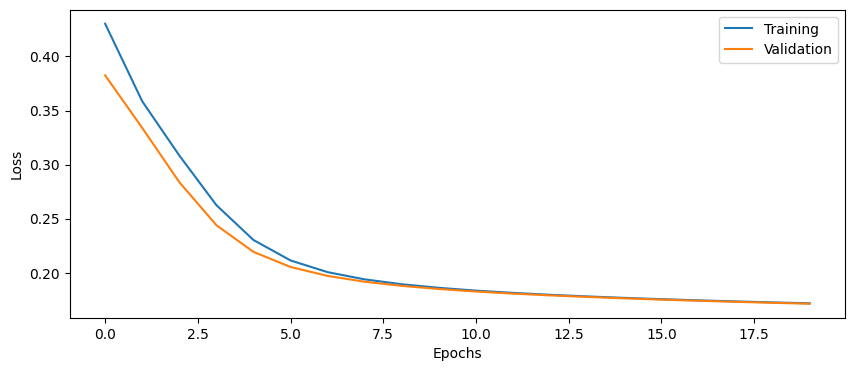

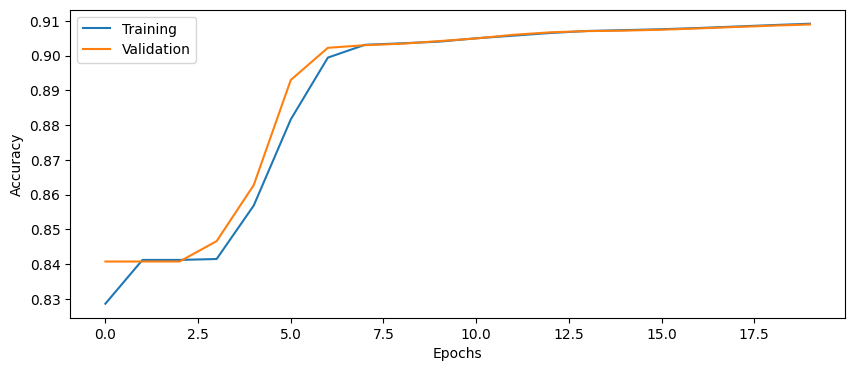

In [15]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


## Answer to Question 5:

If we add several dense layers without specifying activation function, the overall network wouldn't be able to learn complex patterns or relationships in the data, which make it suitable only for tasks where linear models are sufficient.

## Answer to Question 6:
Since we use the the Sequential function provided by tensorflow.keras to build a model, so it's will use a method called Glorot uniform initialization(It is also called Xavier initialization) to init the weights of the dense layers.

The init value of the weight will be the following.

For a dense layer with $n_{in}$ input units and $n_{out}$ output units, the weight init number will follow a uniform distribution and it's value between $[-\sqrt{\frac{6}{n_{in} + n_{out}}},\sqrt{\frac{6}{n_{in} + n_{out}}}]$.

Bias weights will be initialized to zero.



# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [16]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes = np.unique(Ytrain),
                                                  y = Ytrain)
# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights,
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}


[3.14821899 0.59440307]


### 2 layers, 20 nodes, class weights

In [17]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build and train model
model2 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history2 = model2.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)



In [18]:
# Evaluate the model on the test data
score = model2.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2337 - accuracy: 0.9003
Test loss: 0.2337
Test accuracy: 0.9003


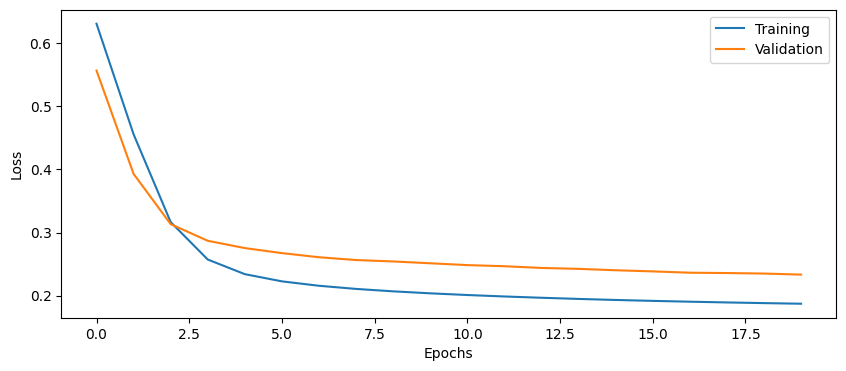

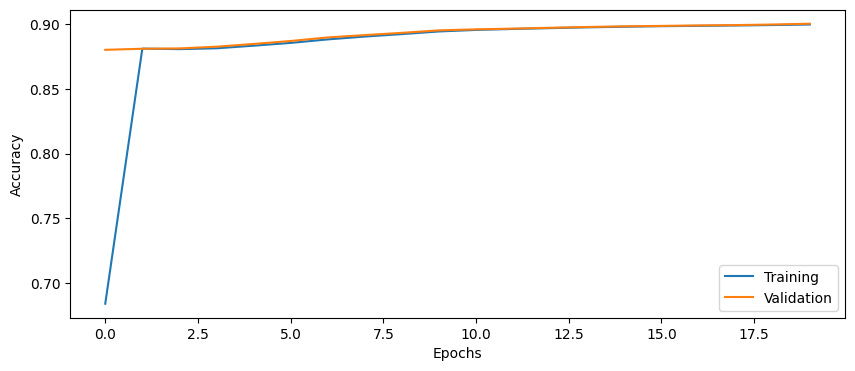

In [19]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results.

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

## Answer to question 7

The reasons we use mini batch are the following:

1. Memory efficiency:For neural networks, it often trained on large datasets, which may not fit into GPU memory in one go. By use mini batch, we can process the subset of the original data set.

2. Regularization: Training use mini batch will introduce noise into the learning process, and this can be treated as a regularization.

3. SGD: When we use mini batch, it allow us to perform SGD, which means the parameters will update after every mini batch finish, and it will give more chances to escape the local minimal or local max value. If we do not use mini batch, it will update the parameters only once after all the training data been processed, which will result in the local min/max .

4. Computational Efficiency: When we use GPU or even multi-GPU environment, mini batch can help to run the batch more efficiently by take advantage of parallel processing.

The reason that we do not use all data at once is already mentioned above.

## Answer to question 8
When we change the batch size from 10000 to 1000 and 100, we got the following data.When we change to small batch size, the training time get much longer.(model 2)

1. When batch size = 10000, it runs around 12 seconds
2. When batch size = 1000, it runs around 82 seconds
3. When batch size = 100, it runs around 399 seconds

About the GUP usage and used graphics card memory as follows.

1. GPU max usage is around 18-27% depend on batch size
2. GPU Mem is around 1151-2175MiB accordingly.

## Answer to question 9

We change the epoc to 1 and batch size to 100,1000 and 10000 respectively. And we get the following data

1. When batch size = 10000, it runs around 2 seconds
2. When batch size = 1000, it runs around 4 seconds
3. When batch size = 100, it runs around 22 seconds

The reason is because GPU has many cuda cores and can parallel processing data. And for T4 card, it has 2560 cuda cores which is greater than 1000. So batch size should set according to the current GPU card to utlize the parallel processing function of the GPU.


## Answer to question 10

According to the dataset, for training data, we have 534895 records.

That means:

1. if batch size = 100, the weight will update around 5348 times
2. if batch size = 1000, the weight will update around 534 times
3. if batch size = 10000, the weight will update around 53 times

## Answer to question 11

There have severl factors that limit the size of batch size.

1. Memory Constraints. One of the main constraints is memory size especially GPU mem size.

2. Generalization Performance. Smaller batch size sometimes can get better result, and can help to avoid local min/max if we use SGD to update parameters.

3. Computational Efficiency. large batch can lead to fast convergence but it also need more computation pre loop.

4. Model Architecture and dataset Characteristics. With different dataset and model architecture, for example, simple model can increase batch size to utlizer the parallelism of the GPU while complex model with high-dimensional inputs, we should decrease batch size to make sure the model is fully trained.

So based on the factors mentioned above, we should choose batch size based on the problem we are facing and do some test to choose the most efficient and proper one.

## Answer to question 12

When we decreasing the batch size, the noise in the gradient estimates increases which can cause optimization process  become more unstable. Since there is more uncertainty (noise) in the gradient, we should decrease the LR in order to take smaller steps in the parameters space.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

### 4 layers, 20 nodes, class weights

In [20]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 4
n_nodes = 20
learning_rate = 0.1

# Build and train model
model3 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history3 = model3.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [21]:
# Evaluate the model on the test data
score = model3.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2595 - accuracy: 0.8854
Test loss: 0.2595
Test accuracy: 0.8854


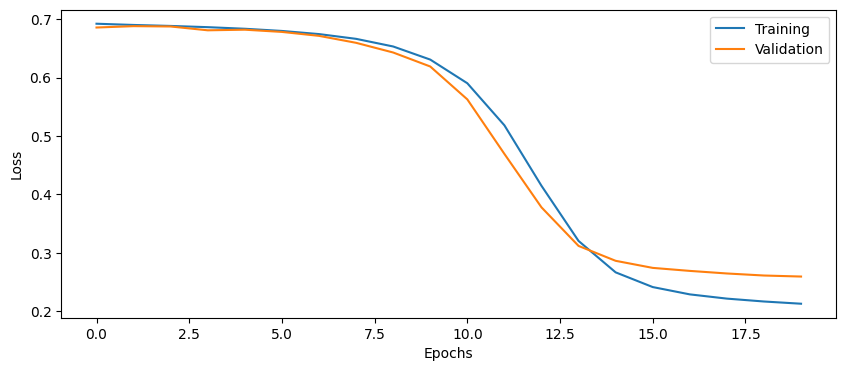

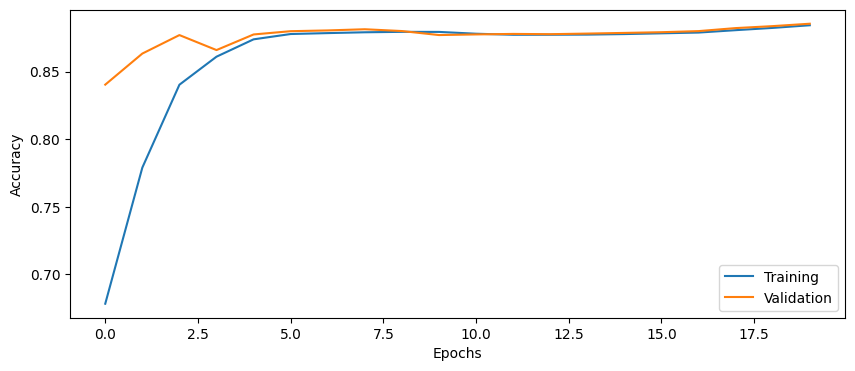

In [22]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [23]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 50
learning_rate = 0.1

# Build and train model
model4 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history4 = model4.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [24]:
# Evaluate the model on the test data
score = model4.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 24ms/step - loss: 0.2327 - accuracy: 0.9012
Test loss: 0.2327
Test accuracy: 0.9012


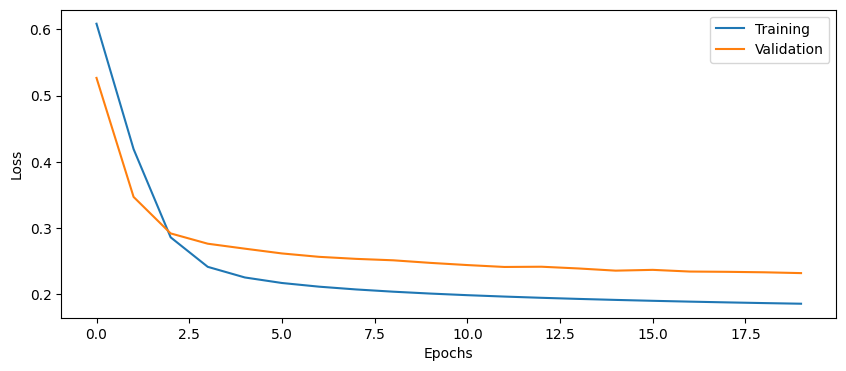

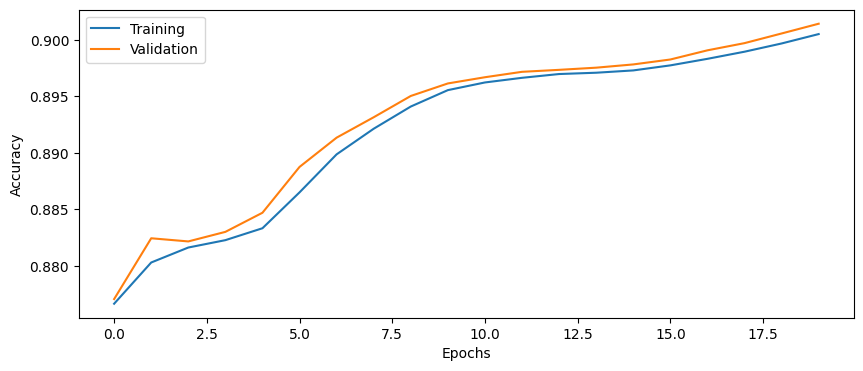

In [25]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [26]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 4
n_nodes = 50
learning_rate = 0.1

# Build and train model
model5 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history5 = model5.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                4650      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12351 (48.25 KB)
Trainable params: 12351 (48.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Evaluate the model on the test data
score = model5.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 1s 70ms/step - loss: 0.2497 - accuracy: 0.8965
Test loss: 0.2497
Test accuracy: 0.8965


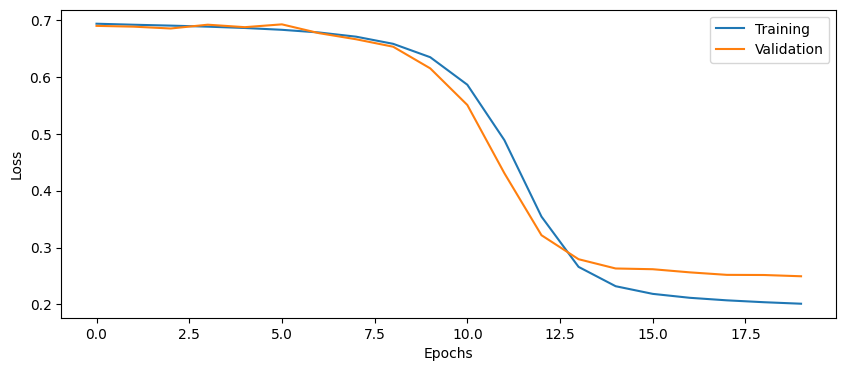

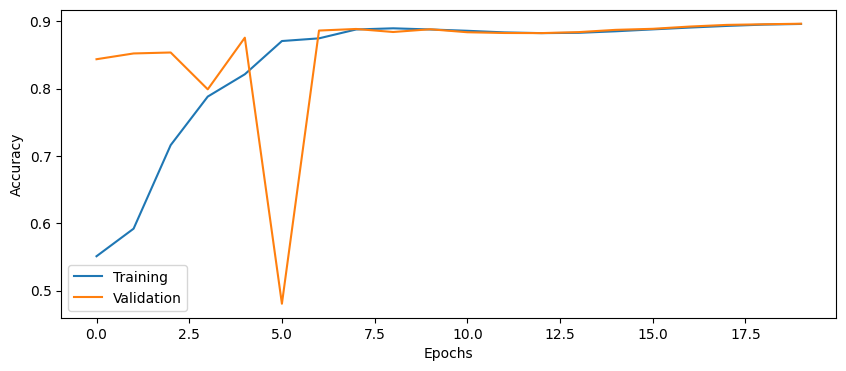

In [28]:
plot_results(history5)

In [29]:
model2.summary() # 2 layers and 20 nodes
model5.summary() # 4 layers and 50 nodes

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1860      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2301 (8.99 KB)
Trainable params: 2301 (8.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                4650      
                                                                 


## Answer to question 13

Trainable parameters of 4 dense layers with 50 nodes is 12351.

Trainable parameters of 2 dense layers with 20 nodes is 2301.

| model | layer | node | parameters num |
|:---:  |:-----:|:----:|:--------------:|
|model2 |2      |    20|            2301|
|model5 |4      |    50|           12351|

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers.

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

## Answer to question 14

The reasons why batch normalization is important are:

1. It can help to stabilize the gradient propagation.
In deep networks, gradients can become unstable may become unstable as they will backward propagate through many layers of the network.This can lead to vanishing or exploding gradients.

2. It makes high learning rate possible. The batch normalization minimize the dependency of gradients on the parameters or activation function.

3. Reduce the impact of the weight init value. The batch normalization can help to minimize the dependency on init value which make it much easier to design and training the deep neural network.

In simpler words, batch normalization does something similar to normalizing input data but on the intermediate values in the hidden layers. Thus, it helps to avoid distribution shift in hidden layers, and too large or small values, which ultimately makes training more stable.


### 2 layers, 20 nodes, class weights, batch normalization

In [30]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build and train model
model6 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=True,use_dropout=False,use_custom_dropout=False)

history6 = model6.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [31]:
# Evaluate the model on the test data
score = model6.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2063 - accuracy: 0.9174
Test loss: 0.2063
Test accuracy: 0.9174


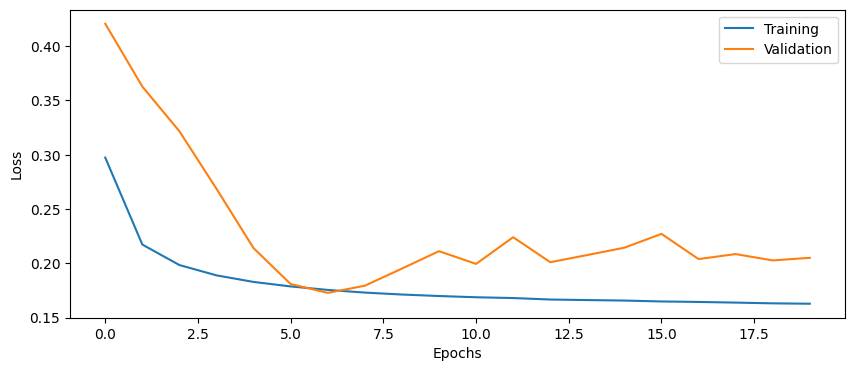

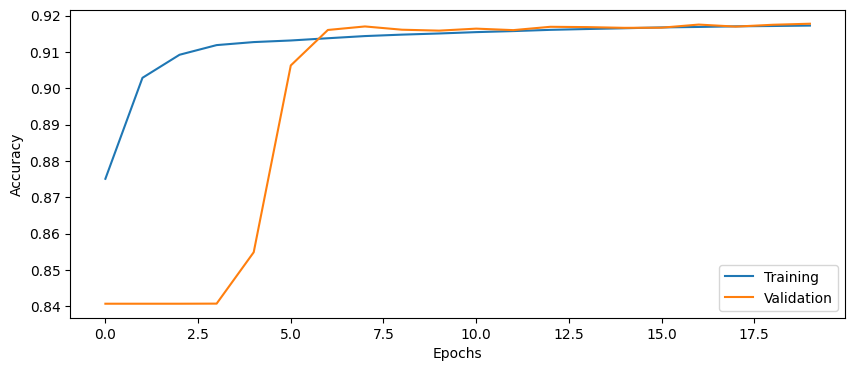

In [32]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [33]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build and train model
model7 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='relu',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history7 = model7.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [34]:
# Evaluate the model on the test data
score = model7.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 1s 61ms/step - loss: 0.2083 - accuracy: 0.9164
Test loss: 0.2083
Test accuracy: 0.9164


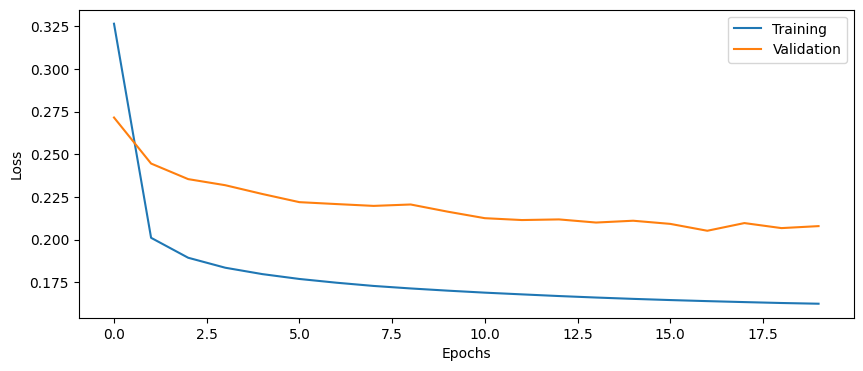

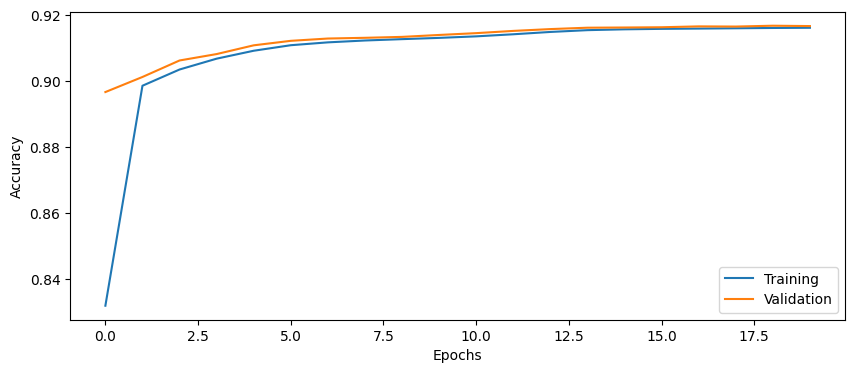

In [35]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers.

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [36]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build and train model
model8 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='adam',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history8 = model8.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [37]:
# Evaluate the model on the test data
score_test = model8.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score_test[0])
print('Test accuracy: %.4f' % score_test[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.1727 - accuracy: 0.9220
Test loss: 0.1727
Test accuracy: 0.9220


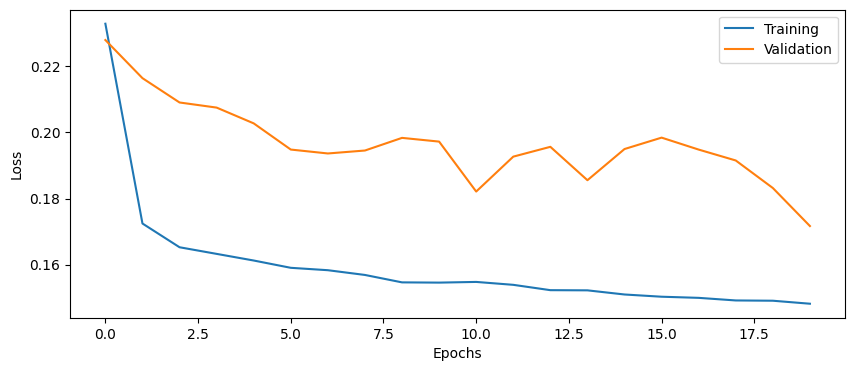

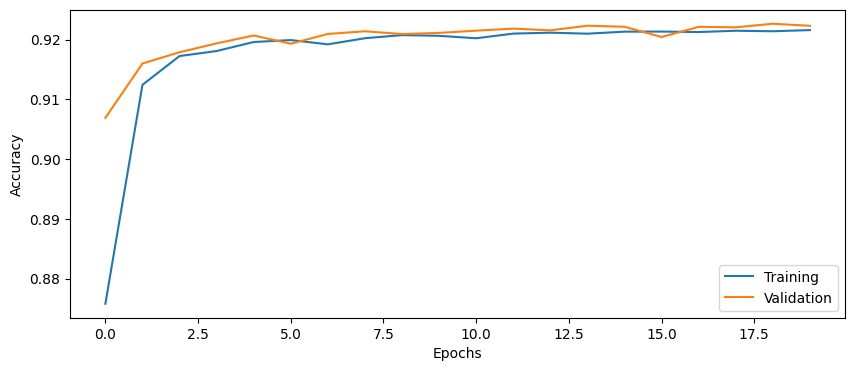

In [38]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [39]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92
n_layers = 2
n_nodes = 20
learning_rate = 0.1

# Build and train model without dropout
model9_1 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history9_1 = model9_1.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

# Build and train model with dropout
model9_2 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='sgd',learning_rate=learning_rate,
                   use_bn=False,use_dropout=True,use_custom_dropout=False)

history9_2 = model9_2.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [40]:
# Evaluate the model on the test data
score_test_1 = model9_1.evaluate(Xtest,Ytest,batch_size=batch_size)
score_validate_1 = model9_1.evaluate(Xval,Yval,batch_size=batch_size)

score_test_2 = model9_2.evaluate(Xtest,Ytest,batch_size=batch_size)
score_validate_2 = model9_2.evaluate(Xval,Yval,batch_size=batch_size)

print("without dropout\n")
print('Test loss: %.4f' % score_test_1[0])
print('Test accuracy: %.4f' % score_test_1[1])
print('Validate loss: %.4f' % score_validate_1[0])
print('Validate accuracy: %.4f' % score_validate_1[1])

print("with dropout\n")
print('Test loss: %.4f' % score_test_2[0])
print('Test accuracy: %.4f' % score_test_2[1])
print('Validate loss: %.4f' % score_validate_2[0])
print('Validate accuracy: %.4f' % score_validate_2[1])


12/12 [==============================] - 0s 4ms/step - loss: 0.2725 - accuracy: 0.8835
without dropout

Test loss: 0.2334
Test accuracy: 0.9028
Validate loss: 0.2330
Validate accuracy: 0.9028
with dropout

Test loss: 0.2726
Test accuracy: 0.8831
Validate loss: 0.2725
Validate accuracy: 0.8835


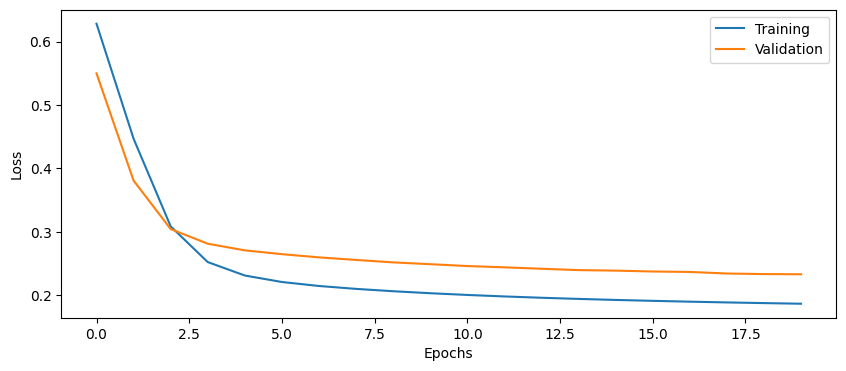

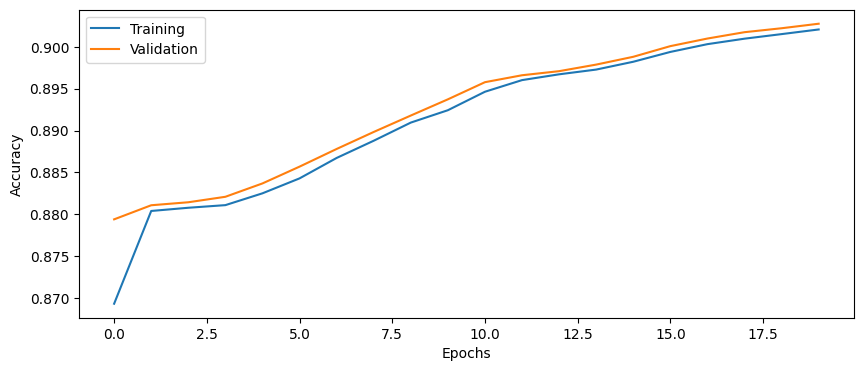

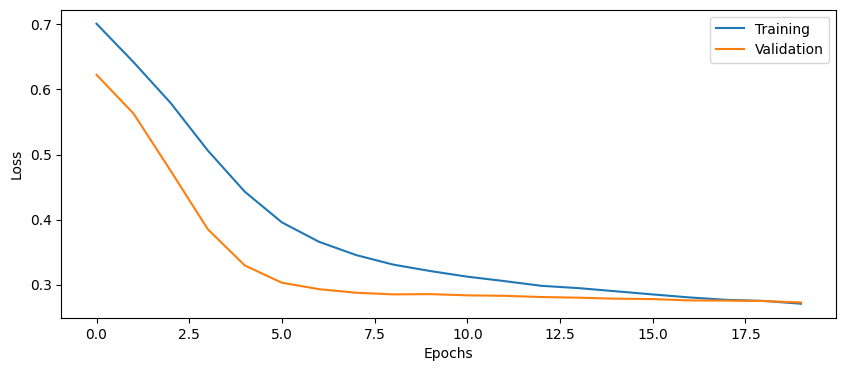

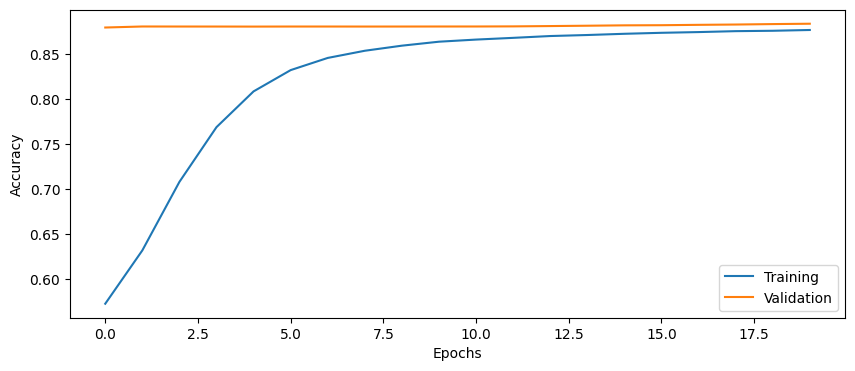

In [41]:
plot_results(history9_1)
plot_results(history9_2)

# Answer to question 15 & 16

Accordng to the table below, we found that test and validate accuracy decrease if we add dropout

|with/out dropout|Test loss|Test accuracy|Validate loss|Validate accuracy|
|----------------|---------|-------------|-------------|-----------------|
|NO              |0.2334   |0.9028       |0.2330       |0.9028           |
|YES             |0.2726   |0.8831       |0.2725       |0.8835           |

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

## Answer to question 17

The classification accuracy is 0.9370, We can get a better result 0.9559 if we set use_bn=true , however we found the validation set's accuracy value fluctuate a lot, which is not what we expected. And it also effect the next cell(dropout)'s performace drop to around 0.84, so we choose not use batch normization.

The best configuration is as follows.

batch_size = 5000

epochs = 300

input_shape = 92

n_layers = 6

n_nodes = 20

learning_rate = 0.005



In [42]:
# Setup some training parameters
batch_size = 5000
epochs = 300
input_shape = 92
n_layers = 6
n_nodes = 20
learning_rate = 0.005

# Build and train model
model10 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='adam',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=False)

history10 = model10.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)


In [43]:
# Evaluate the model on the test data
score = model10.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

23/23 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.9370
Test loss: 0.1685
Test accuracy: 0.9370


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on.

Question 18: What is the mean and the standard deviation of the test accuracy?

In [44]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training


    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training:
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [45]:
# Setup some training parameters
batch_size = 5000
epochs = 300
input_shape = 92
n_layers = 6
n_nodes = 20
learning_rate = 0.05

# Build and train model
model11 = build_DNN(input_shape=input_shape,n_layers=n_layers,n_nodes=n_nodes,
                   act_fun='sigmoid',optimizer='adam',learning_rate=learning_rate,
                   use_bn=False,use_dropout=False,use_custom_dropout=True)

history11 = model11.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,
                      verbose=0,validation_data=(Xval,Yval),
                      class_weight=class_weights)

In [46]:
# Run this cell a few times to evalute the model on test data,
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest,Ytest,batch_size=batch_size)

print('Test accuracy: %.4f' % score[1])

23/23 [==============================] - 0s 3ms/step - loss: 0.2236 - accuracy: 0.9133
Test accuracy: 0.9133


In [47]:
# Run the testing 100 times, and save the accuracies in an array

accuracies = np.zeros(100)
for i in range(100):
  accuracies[i] = model11.evaluate(Xtest,Ytest,batch_size=batch_size)[1]

# Calculate and print mean and std of accuracies
print("Mean of test accuracy is %.4f" % np.mean(accuracies))
print("Std of test accuracy is %.4f" % np.std(accuracies))



23/23 [==============================] - 0s 3ms/step - loss: 0.2237 - accuracy: 0.9133
Mean of test accuracy is 0.9132
Std of test accuracy is 0.0002


## Answer to question 18

Mean of test accuracy is 0.9132

Std of test accuracy is 0.0002

# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234.

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [48]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation

k_folds = 10

skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

test_accuracies = []

# Loop over cross validation folds
for train_index, test_index in skf.split(Xtrain, Ytrain):
    X_train_fold, X_test_fold = Xtrain[train_index], Xtrain[test_index]
    Y_train_fold, Y_test_fold = Ytrain[train_index], Ytrain[test_index]

    # Calculate class weights for current split
    cv_class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes = np.unique(Y_train_fold),
                                                  y = Y_train_fold)
    cv_class_weights = {0: cv_class_weights[0],
                        1: cv_class_weights[1]}

    # Rebuild the DNN model, to not continue training on the previously trained model
    cv_model = build_DNN(input_shape=input_shape, n_layers=n_layers, n_nodes=n_nodes,
                      act_fun='sigmoid', optimizer='adam', learning_rate=learning_rate,
                      use_bn=False, use_dropout=False, use_custom_dropout=False)

    # Fit the model with training set and class weights for this fold
    cv_history = cv_model.fit(X_train_fold, Y_train_fold, batch_size=batch_size, epochs=epochs,
                        verbose=0, validation_data=(Xval, Yval), class_weight=cv_class_weights)


    # Evaluate the model using the test set for this fold
    test_loss, test_accuracy = cv_model.evaluate(X_test_fold, Y_test_fold,batch_size=batch_size)

    # Save the test accuracy in an array
    test_accuracies.append(test_accuracy)

# Calculate and print mean and std of accuracies
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)


11/11 [==============================] - 0s 43ms/step - loss: 0.2073 - accuracy: 0.9172
Mean Accuracy: 0.9168023765087128
Standard Deviation of Accuracy: 0.0031786514229869165


## Answer to question 19

Mean Accuracy:  0.9168023765087128

Standard Deviation of Accuracy: 0.0031786514229869165

## Answer to question 20

The main advantage of dropout compared to cross-validation is its efficiency and simplicity.During training process, dropout randomly sets a fraction of the neurons in a layer to zero, which can prevent the overfitting.

Another advantage is dropout-based uncertainty estimation is computationally more efficient, compare to the CV's implementation.

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

## Answer to Question 21

We can change the output layer with a linear activation function and we should also change the loss function to MSE which is commonly used in regression problems.

## Report

Send in this jupyter notebook, with answers to all questions.